In [87]:
import torch
import torchtext
from torchtext import datasets
import torch.nn as nn
import torch.nn.functional as F
import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import os
import spacy # use <!pip install spacy> and <!python -m spacy download en> if you dont have spacy
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import torch.optim as optim

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
#select the path where you want to save model prameters

PATH = '/home/sanala/Juputer try/HSD/model-parameters/bi-lstm-hasoc.pt'


#Select which data you want to work with 
#data path
DataPath= '/home/sanala/Juputer try/HSD'   #change it to your path
#data
train_data='has21_traindata.csv'           #<has20_traindata.csv> or <has21_traindata.csv> or <has19-20-21_conmined_train.csv>
valid_data='has21_devdata.csv'             #<has21_devdata.csv> or <has21_devdata.csv> or <has19-20-21_conmined_valid.csv>
test_data= 'has21_testwithlabels.csv'      #<has21_testdata.csv> or <has21_testdatawithlabels.csv> <has21_testdata.csv>


    
def hasoc_combined_data():
    data1a = pd.read_csv('has19_traindata.csv')
    data2b = pd.read_csv('has19_devdata.csv')
    data1aa = pd.read_csv('has20_traindata.csv')
    data2bb = pd.read_csv('has20_devdata.csv')
    data1aaa = pd.read_csv('has21_traindata.csv')
    data2bbb = pd.read_csv('has21_devdata.csv')
    
    train_data, valid_data = pd.concat([data1a, data1aa, data1aaa]), pd.concat([data2b, data2bb, data2bbb])
    test_data='has21_testwithlabels.csv'
    #if datayear == '2020':
            #print('Using Hasoc combined data for Hasoc 2020 test data... ')
            #testdata = pd.read_csv(args.has20_testdata)
    #else:
            #print('Using Hasoc combined data for Hasoc 2021 test data... ')
    train_data.to_csv('/home/sanala/Juputer try/HSD/has19-20-21_conmined_train.csv')
    valid_data.to_csv('/home/sanala/Juputer try/HSD/has19-20-21_conmined_valid.csv')
    

#set to True if you want to work with hasoc_combined 19_20_21
hasoc_combined=False

if hasoc_combined:
    hasoc_combined_data()
    train_data='has19-20-21_conmined_train.csv'           #<has21_traindata.csv> or <has_combined_traindata.csv>
    valid_data='has19-20-21_conmined_valid.csv'             #<has21_devdata.csv> or <has21_devdata.csv>
    test_data= 'has21_testdatawithlabels.csv'
    

#pre-preocessing 
def text_clean(text):
    text = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', text)                  # remove emails                    
    text = re.sub(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', text)# remove IP address
    text = re.sub(r'http\S+', '', text)                                          # remove URLs
    text = re.sub(r'www\S+ ', '', text)                                          # remove URLs
    text = re.sub(r'[^\w\s#@/:%.,_-]', '', text, flags=re.UNICODE)               # remove emojis+
    text = re.sub(r'[#,@,&,<,>,\,/,-]', '', text)
    #text = text.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
    text = text.replace('[','')
    text = text.replace(']','')
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.replace(' {2,}', ' ')                                            # remove 2 or more spaces
    text = text.strip()
    text = text.lower()
    text = re.sub(r'\d', '', text)                                              # remove numbers

    return text

# define model
class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, 
                           bidirectional = bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))
        
        output, hidden = self.rnn(embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
       
        return self.fc(hidden.squeeze(0))
    
#define function to plot training  loss vs validation loss to check  overfitting     
def plotLosses(train_losses,val_losses):
    plt.plot(train_losses,label='Training Loss')  
    plt.plot(val_losses,label='Validation Loss')  
    plt.legend() 
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
#function to return  scors   
def f1_score_func(preds, labels):
    return f1_score(labels, preds, average=None), f1_score(labels, preds, average="weighted"), f1_score(labels, preds, average="micro")

#training function 
def train(model, train_iterator, optimizer, criterion):
    print ('start training' )   
    
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    
    for batch in train_iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text)
        
        loss = criterion(predictions, batch.task_2)
        
        acc = categorical_accuracy(predictions, batch.task_2)
        
        loss.backward()
        
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc += acc.item()
        
    return train_epoch_loss / len(train_iterator), train_epoch_acc / len(train_iterator)

#Evaluation  function
def evaluation(model,valid_iterator):
    print('Thin is the validation result')
    valid_epoch_loss = 0
    valid_epoch_acc = 0
    predictions_tst = []
    true_vals=[]
    model.eval()
    with torch.no_grad():

      for batch in valid_iterator:

            predictions = model(batch.text)
            #print( predictions)
            pred=predictions.argmax(1, keepdim = True)
            pred = pred.transpose(1,0)
            pred=pred.squeeze()
            #print(pred)
            #print(batch.task_2)

            for a in pred:            # pick each element - no list comprehension
              predictions_tst.append(a)
            for a in batch.task_2: 
              true_vals.append(a)

            loss = criterion(predictions, batch.task_2)
            
            acc = categorical_accuracy(predictions, batch.task_2)

            valid_epoch_loss += loss.item()
            valid_epoch_acc += acc.item()
    predictions_tst = torch.stack(predictions_tst)
    true_vals = torch.stack(true_vals)
 
       
    return valid_epoch_loss / len(valid_iterator), valid_epoch_acc / len(valid_iterator ),predictions_tst,true_vals    

#test function

def test(model, test_iterator,path):
    print ('this the testing result' )   

    epoch_loss = 0
    epoch_acc = 0
    model.load_state_dict(torch.load(path))

    model.eval()
    predictions_tst = []
    true_vals=[]
    IDs=[]

    with torch.no_grad():

        for batch in test_iterator:

            predictions = model(batch.text)
            #print( predictions)
            pred=predictions.argmax(1, keepdim = True)
            pred = pred.transpose(1,0)
            pred=pred.squeeze()
            #print(pred)
            #print(batch.task_2)

            for a in pred:            # pick each element - no list comprehension
                predictions_tst.append(a)
            for a in batch.task_2: 
                true_vals.append(a)

            for a in batch._id: 
                IDs.append(a)#better if it was a dictionary (id:label)
            
            loss = criterion(predictions, batch.task_2)
            
            acc = categorical_accuracy(predictions, batch.task_2)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    predictions_tst = torch.stack(predictions_tst)
    true_vals = torch.stack(true_vals)
 
    test_loss = epoch_loss / len(test_iterator)
    test_acc = epoch_acc / len(test_iterator)
    return test_loss , test_acc,predictions_tst,true_vals,IDs

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

#function to test user input
def predict_class(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed)
    tensor = tensor.unsqueeze(1)
    preds = model(tensor)
    preds=preds.view(1,len(LABEL.vocab))
    max_preds = preds.argmax(1, keepdim = True)
    return max_preds.item()

In [88]:
#train_data='has21_traindata.csv'           #<has20_traindata.csv> or <has21_traindata.csv> or <has19-20-21_conmined_train.csv>
#valid_data='has21_devdata.csv'             #<has21_devdata.csv> or <has21_devdata.csv> or <has19-20-21_conmined_valid.csv>
#test_data= 'has21_testwithlabels.csv'      #<has21_testdata.csv> or <has21_testdatawithlabels.csv> <has21_testdata.csv>
#test_data=pd.read_csv('has21_testwithlabels.csv')

#test_data.head()

In [89]:
#start pre-processin
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def tokenizer(s): 
    return [w.text.lower() for w in nlp(text_clean(s))]
TEXT = torchtext.legacy.data.Field(tokenize = tokenizer)

LABEL = torchtext.legacy.data.LabelField()
ID = torchtext.legacy.data.RawField()

datafields = [('_id', ID) ,('text', TEXT),('task_1', None) ,('task_2', LABEL)]

#read data
#change the path 
trn,vld, tst = torchtext.legacy.data.TabularDataset.splits(path =DataPath, 
                                                train = train_data,
                                                validation=valid_data,
                                                test = test_data,    
                                                format = 'csv',
                                                skip_header = True,
                                                fields = datafields)
#check data
#print(f'Number of training examples: {len(trn)}')
#print(f'Number of validation examples: {len(vld)}')
#print(f'Number of testing examples: {len(tst)}')

#print(vars(trn.examples[0]))
#print(vars(tst.examples[50]))

TEXT.build_vocab(trn, max_size=25000,
                 vectors="glove.6B.100d",## #pretrained vectors are ['charngram.100d', 'fasttext.en.300d', 'fasttext.simple.300d', 'glove.42B.300d', 'glove.840B.300d', 'glove.twitter.27B.25d', 'glove.twitter.27B.50d', 'glove.twitter.27B.100d', 'glove.twitter.27B.200d', 'glove.6B.50d', 'glove.6B.100d', 'glove.6B.200d', 'glove.6B.300d']
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(trn)
#print(LABEL.vocab.stoi)
train_iterator,valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
                                (trn,vld, tst),
                                batch_size = 50,
                                sort_key=lambda x: len(x.text),
                                sort_within_batch=False,
                                device = device)

In [90]:

input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 20
output_dim = len(LABEL.vocab)
n_layers = 2
bidirectional = True
dropout = 0.5
model = RNN(input_dim, 
            embedding_dim, 
            hidden_dim, 
            output_dim, 
            n_layers, 
            bidirectional, 
            dropout)
pretrained_embeddings = TEXT.vocab.vectors

#print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

optimizer = optim.Adam(model.parameters())

model=model.to(device)
#criterion = nn.BCEWithLogitsLoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
#print(model.embedding.weight.data)

start training
Thin is the validation result
| Epoch: 01 | Train Loss: 1.348 | Train Acc: 34.25% | Valid Loss: 1.312 | Valid Acc: 38.71 | F1: [0.54175153 0.22068966 0.         0.05479452], weighted F1: 0.2681406275732105, micro F1: 0.3922077922077922%
              precision    recall  f1-score   support

           0       0.37      0.99      0.54       135
           1       0.62      0.13      0.22       119
           2       0.00      0.00      0.00        61
           3       0.67      0.03      0.05        70

    accuracy                           0.39       385
   macro avg       0.41      0.29      0.20       385
weighted avg       0.44      0.39      0.27       385

Validation loss decreased (inf --> 1.311618).   Saving model ...
start training
Thin is the validation result
| Epoch: 02 | Train Loss: 1.307 | Train Acc: 39.14% | Valid Loss: 1.267 | Valid Acc: 45.29 | F1: [0.55440415 0.53386454 0.         0.05555556], weighted F1: 0.3695151401362825, micro F1: 0.45714285714285

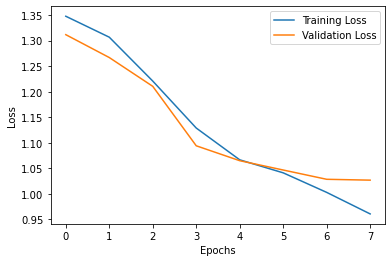

this the testing result
Test Loss: 0.977 | Test Acc: 60.14 F1: [0.67574468 0.75209581 0.28313253 0.1       ], weighted F1: 0.5420380007613562, micro F1: 0.600312256049961 % 
              precision    recall  f1-score   support

           0       0.57      0.82      0.68       483
           1       0.69      0.83      0.75       379
           2       0.44      0.21      0.28       224
           3       0.44      0.06      0.10       195

    accuracy                           0.60      1281
   macro avg       0.53      0.48      0.45      1281
weighted avg       0.56      0.60      0.54      1281



In [91]:
num_epochs = 8
valid_loss_min = np.Inf 
val_losses=[]
train_losses=[]
for epoch in range(num_epochs):
     
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc,predictions,true_vals = evaluation(model, valid_iterator)
    val_f1, val_f1_w, val_f1_mic = f1_score_func(predictions.detach().cpu().numpy(), true_vals.detach().cpu().numpy())
    #val_f1, val_f1_w, val_f1_mic = f1_score_func(predictions, true_vals)
    
    val_losses.append(valid_loss)
    train_losses.append(train_loss)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f} | F1: {val_f1}, weighted F1: {val_f1_w}, micro F1: {val_f1_mic}%')
    print(classification_report(true_vals.detach().cpu().numpy(), predictions.detach().cpu().numpy()))
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,valid_loss))
      valid_loss_min = valid_loss
      torch.save(model.state_dict(), PATH)  
plotLosses(train_losses,val_losses)

test_loss , test_acc,predictions_tst,true_vals,IDs=test(model, test_iterator,PATH)
val_f1, val_f1_w, val_f1_mic = f1_score_func(predictions_tst.detach().cpu().numpy()
, true_vals.detach().cpu().numpy()
)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f} F1: {val_f1}, weighted F1: {val_f1_w}, micro F1: {val_f1_mic} % ')

print(classification_report(true_vals.detach().cpu().numpy(), predictions_tst.detach().cpu().numpy()))

#These are the list of the _id and needed to combine with true_vals to make the CSV for hasoc submission
#print(IDs)

In [92]:
#pred_class = predict_class(model, "sick I hate you mother fucker pitch")
#print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]} with label {pred_class}')